# Generative Adversarial Network
    
Training a GAN i.e training generator to learn to sample that is indistinguishable from MNIST dataset using discriminator network.
    
As the generator trains, it figures out how to map latent vectors from latent space to recognizable images which is undistinguishable for the discriminator.

Once the model is trained, discriminator is removed and output from the generator is used for the same.

# High level view of GAN architecture 

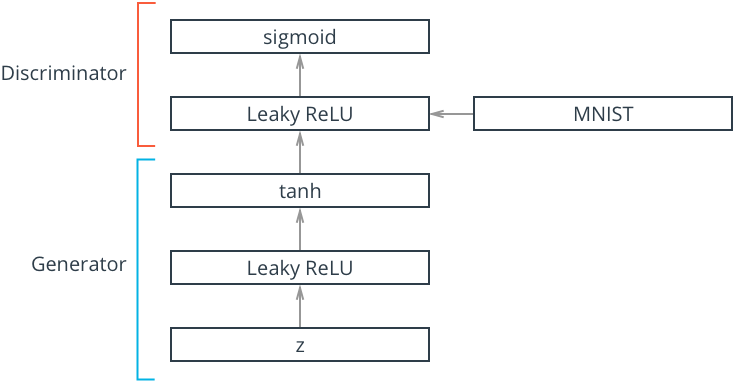

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [4]:
from torchvision import datasets               #Download the dataset
import torchvision.transforms as transforms    #Import the transform to modify image features

In [5]:
# set data loading subprocesses 
num_wrks = 0

# samples per batch
bs = 64

# data to torch.FloatTensor
transform = transforms.ToTensor()

# set the training dataset
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

#set data laoding rules
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs,
                                           num_workers=num_wrks)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


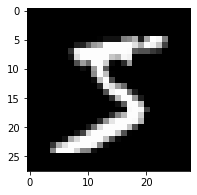

In [6]:
# obtain 1st batch of images from training data

dataiter = iter(train_loader)
images, labels = dataiter.next() #call for 1st batch of training data
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [7]:
#Make use of torch NN class functionalities

import torch.nn as nn
import torch.nn.functional as F


# Create discriminator class

## Discriminator

The discriminator network is going to be a typical linear classifier. To make this network a universal function approximator, we need add atleast one hidden layer, and these hidden layers should have one key attribute.

In [8]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()                 #Access to the parent class
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


# Generator

The generator network is similar to discriminator architecture except,we are applying a tanh activation function(scales value between -1 to 1) to our output layer.

In [9]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()                   #Access to the parent class
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

# Hyperparameters of the model

In [10]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

# Instantiating the adversial networks

In [11]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# Loss function for Discriminator

Discriminator is calculated as the sum of losses for fake and real images i.e d_loss = d_real_loss + d_fake_loss where Discriminator should out 1 for real images and 0 for fake images

#Loss function for Generator

The generator loss will look similar only with flipped labels.  Where flipped indicates that generator is trying to fool the discriminatorthat the images it generates (fakes) are real

In [12]:
# Calculate losses

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss by comparing with labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss by comparing with labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

# Setting the Optimizers

In [13]:
import torch.optim as optim

# Optimizers
lr = 0.002

# setting optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

# Training the dataset

In [14]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.4028 | g_loss: 0.7403
Epoch [    1/  100] | d_loss: 1.6525 | g_loss: 0.4293
Epoch [    1/  100] | d_loss: 1.2261 | g_loss: 1.1564
Epoch [    2/  100] | d_loss: 1.2452 | g_loss: 1.0397
Epoch [    2/  100] | d_loss: 1.4453 | g_loss: 0.8853
Epoch [    2/  100] | d_loss: 1.1389 | g_loss: 1.4336
Epoch [    3/  100] | d_loss: 1.0027 | g_loss: 1.3422
Epoch [    3/  100] | d_loss: 0.8268 | g_loss: 2.0876
Epoch [    3/  100] | d_loss: 0.8921 | g_loss: 1.4504
Epoch [    4/  100] | d_loss: 1.1419 | g_loss: 1.8068
Epoch [    4/  100] | d_loss: 1.1131 | g_loss: 1.4718
Epoch [    4/  100] | d_loss: 1.3069 | g_loss: 1.5066
Epoch [    5/  100] | d_loss: 1.0417 | g_loss: 1.4158
Epoch [    5/  100] | d_loss: 1.0873 | g_loss: 1.2912
Epoch [    5/  100] | d_loss: 1.3385 | g_loss: 0.8540
Epoch [    6/  100] | d_loss: 1.1992 | g_loss: 1.2645
Epoch [    6/  100] | d_loss: 1.1317 | g_loss: 1.8718
Epoch [    6/  100] | d_loss: 1.1176 | g_loss: 1.6712
Epoch [    7/  100] | d_loss

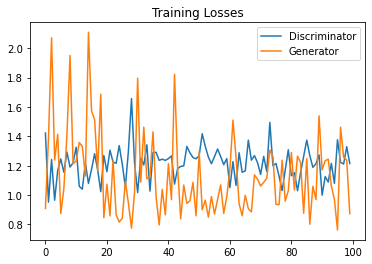

In [15]:


fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


In [16]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [17]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

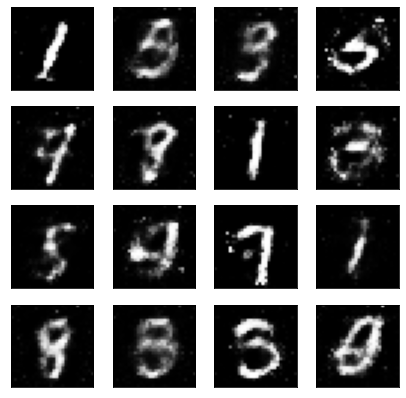

In [18]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

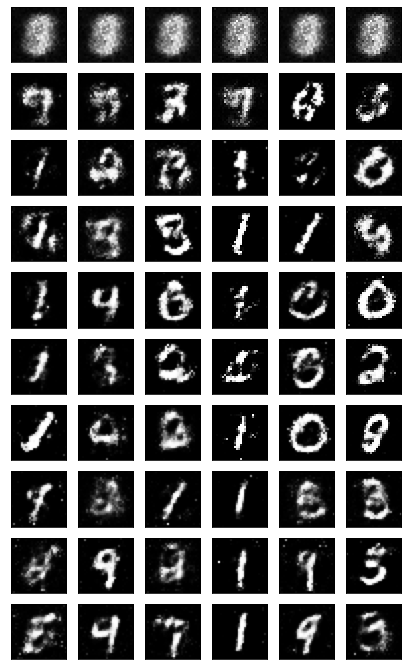

In [19]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)